<a href="https://colab.research.google.com/github/KimMunho/ComputerVision/blob/main/HW3/HW3_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


base-ReLU-CrossEntropy-SGD 완료
base-ReLU-MSE+Softmax-SGD 완료
base-ReLU-MSE-Logits-SGD 완료
base-Sigmoid-CrossEntropy-SGD 완료
base-Sigmoid-MSE+Softmax-SGD 완료
base-Sigmoid-MSE-Logits-SGD 완료


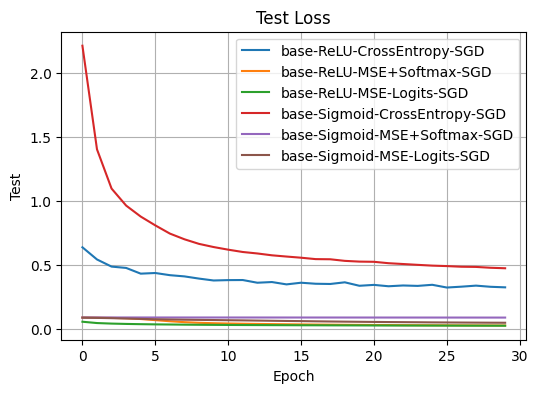

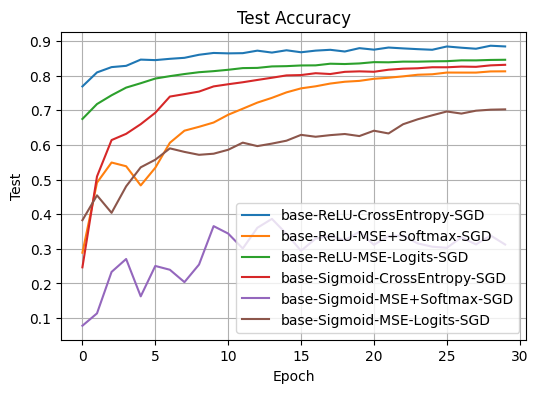

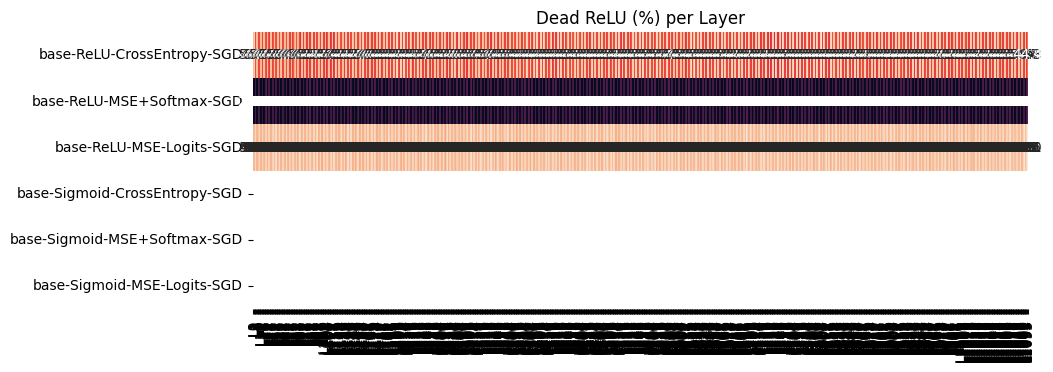

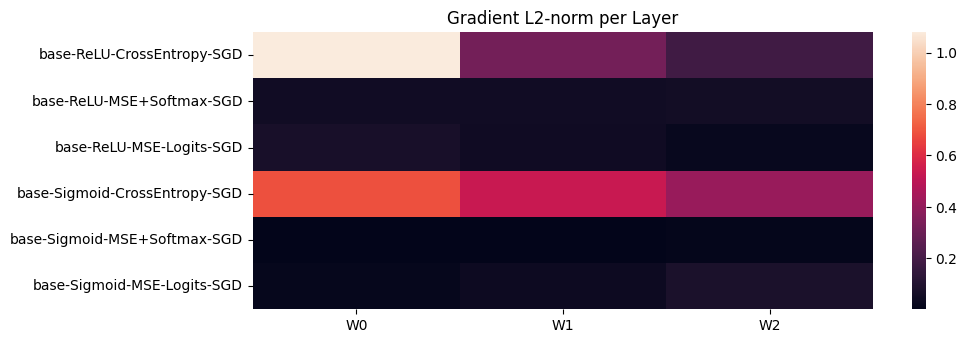

,Depth,Activation,Loss,Optimizer,BestAcc(%),MinLoss,Converged@
0,base,ReLU,CrossEntropy,SGD,88.61,0.324,25
1,base,ReLU,MSE+Softmax,SGD,81.22,0.027,29
2,base,ReLU,MSE-Logits,SGD,84.55,0.026,29
3,base,Sigmoid,CrossEntropy,SGD,83.10,0.474,29
4,base,Sigmoid,MSE+Softmax,SGD,38.65,0.089,29
5,base,Sigmoid,MSE-Logits,SGD,70.24,0.049,29


In [ ]:
!pip -q install torch torchvision tqdm seaborn

import copy, random, time, os, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from IPython.display import display

# ◇ 설정 ───────────────────────────────────────────────────────
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CFG = dict(
    depth_layers = [256,128],                     # base 모델
    activations  = {"ReLU": nn.ReLU(),
                    "Sigmoid": nn.Sigmoid()},
    losses       = {                              # (loss_fn, use_softmax)
        "CrossEntropy": (nn.CrossEntropyLoss(), False),
        "MSE+Softmax": (nn.MSELoss(),           True),
        "MSE-Logits" : (nn.MSELoss(),           False)
    },
    lr       = 0.05,                              # SGD 고정
    epochs   = 30,
    batch    = 128,
    seed     = 42,
)
random.seed(CFG["seed"]); np.random.seed(CFG["seed"]); torch.manual_seed(CFG["seed"])

# ◇ 데이터 ─────────────────────────────────────────────────────
tx = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.FashionMNIST(".", train=True , download=True, transform=tx)
test_ds  = datasets.FashionMNIST(".", train=False, download=True, transform=tx)
train_dl = DataLoader(train_ds, CFG["batch"], shuffle=True , num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds , CFG["batch"], shuffle=False, num_workers=2, pin_memory=True)
INPUT, CLASSES = 28*28, 10

# ◇ 모델 ───────────────────────────────────────────────────────
class MLP(nn.Module):
    def __init__(self, layers, act):
        super().__init__()
        mods, prev = [], INPUT
        for h in layers:
            mods += [nn.Linear(prev, h), copy.deepcopy(act)]; prev = h
        mods.append(nn.Linear(prev, CLASSES))
        self.net = nn.Sequential(*mods)

        self._acts = []                    # ReLU 활성 모니터링
        for m in self.net:
            if isinstance(m, nn.ReLU):
                m.register_forward_hook(lambda mod,i,o: self._acts.append(o.detach()))
    def forward(self,x): return self.net(x.flatten(1))

# ◇ 학습 / 평가 ────────────────────────────────────────────────
def run_epoch(model, loader, loss_pack, opt=None):
    loss_fn, use_sm = loss_pack
    train = opt is not None
    model.train() if train else model.eval()
    L,A = [],[]
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        if isinstance(loss_fn, nn.MSELoss):
            y_one = F.one_hot(y, CLASSES).float()
            pred  = F.softmax(out,1) if use_sm else out
            loss  = loss_fn(pred, y_one)
        else:
            loss  = loss_fn(out, y)
        if train:
            opt.zero_grad(); loss.backward(); opt.step()
        L.append(loss.item()); A.append((out.argmax(1)==y).float().mean().item())
    return np.mean(L), np.mean(A)

def dead_ratio(acts): return [(a==0).float().mean().item()*100 for a in acts]

# ◇ 실험 루프 ──────────────────────────────────────────────────
records=[]
for act_name, act in CFG["activations"].items():
    for loss_name, loss_pack in CFG["losses"].items():
        tag = f"base-{act_name}-{loss_name}-SGD"
        model = MLP(CFG["depth_layers"], act).to(DEVICE)
        opt   = torch.optim.SGD(model.parameters(), lr=CFG["lr"])

        test_hist, dead_hist, grad_hist = [], [], []
        for epoch in range(CFG["epochs"]):
            run_epoch(model, train_dl, loss_pack, opt)               # 학습
            vl, va = run_epoch(model, test_dl , loss_pack)           # 검증
            test_hist.append((vl,va))
            dead_hist.append(dead_ratio(model._acts)); model._acts.clear()
            grad_hist.append([p.grad.norm().item() if p.grad is not None else 0
                              for p in model.parameters() if p.ndim==2])
        records.append(dict(tag=tag, act=act_name, loss=loss_name,
                            test_hist=test_hist, dead_hist=dead_hist, grad_hist=grad_hist))
        print(tag,"완료")

# ◇ 그래프 ─────────────────────────────────────────────────────
def plot(metric_idx, title):
    plt.figure(figsize=(6,4))
    for r in records:
        plt.plot([v[metric_idx] for v in r['test_hist']], label=r['tag'])
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(title.split()[0])
    plt.legend(); plt.grid(); plt.show()

plot(0,"Test Loss");  plot(1,"Test Accuracy")

# Dead-ReLU 히트맵 (패딩)
max_len = max(len(r['dead_hist'][-1]) for r in records)
dead_mat = np.array([np.pad(r['dead_hist'][-1], (0,max_len-len(r['dead_hist'][-1])),
                            constant_values=np.nan) for r in records])
mask = np.isnan(dead_mat)
plt.figure(figsize=(10,0.6*len(records)))
sns.heatmap(dead_mat, annot=True, fmt=".1f", cbar=False, mask=mask,
            yticklabels=[r['tag'] for r in records],
            xticklabels=[f"L{i}" for i in range(max_len)])
plt.title("Dead ReLU (%) per Layer"); plt.show()

# Gradient 히트맵
grad_mat = np.stack([r['grad_hist'][-1] for r in records])
plt.figure(figsize=(10,0.6*len(records)))
sns.heatmap(grad_mat, annot=False, cbar=True,
            yticklabels=[r['tag'] for r in records],
            xticklabels=[f"W{i}" for i in range(grad_mat.shape[1])])
plt.title("Gradient L2-norm per Layer"); plt.show()

# ◇ 정량 비교표 ────────────────────────────────────────────────
summary=[]
for r in records:
    accs   = [v[1] for v in r['test_hist']]
    losses = [v[0] for v in r['test_hist']]
    summary.append(["base", r['act'], r['loss'], "SGD",
                    f"{max(accs)*100:.2f}", f"{min(losses):.3f}",
                    int(np.argmin(losses))])
df = pd.DataFrame(summary, columns=["Depth","Activation","Loss","Optimizer",
                                    "BestAcc(%)","MinLoss","Converged@"])
display(df)
